In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import datetime
from datetime import timedelta
from time import time
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Bidirectional

In [2]:
df=pd.read_csv('/content/drive/MyDrive/elai/cotton.csv')

In [3]:
df.head()

Price Date  Max Price
0  01-01-2010       3340
1  02-01-2010       3280
2  04-01-2010       3245
3  05-01-2010       3241
4  06-01-2010       3221

In [4]:
# Convert 'Price Date' column to datetime format
df['Price Date'] = pd.to_datetime(df['Price Date'])

In [5]:
# Set 'Price Date' column as the index
df.set_index('Price Date', inplace=True)

In [6]:
df.dtypes

Max Price    int64
dtype: object

In [7]:
print(df.columns)

Index(['Max Price'], dtype='object')


In [8]:
df.head(10)

Max Price
Price Date           
2010-01-01       3340
2010-02-01       3280
2010-04-01       3245
2010-05-01       3241
2010-06-01       3221
2010-07-01       3200
2010-08-01       3200
2010-09-01       3195
2010-11-01       3200
2010-12-01       3200

In [ ]:
# Verify if there are duplicate labels in the index
df.index.duplicated().sum()

14

In [ ]:
# Assuming 'df' is your DataFrame with duplicate index values
df = df[~df.index.duplicated(keep='first')]

In [ ]:
df.index.duplicated().sum()

0

In [ ]:
# Create a new DataFrame with a daily frequency and interpolate missing values
ts_data = df.resample('D').interpolate(method='linear')
# Reset the index to obtain the 'Price Date' column again
ts_data.reset_index(inplace=True)

In [ ]:
ts_data.head(10)

Price Date  Max Price
0 2010-01-01       3340
1 2010-01-02       3340
2 2010-01-03       3340
3 2010-01-04       3326
4 2010-01-05       3326
5 2010-01-06       3326
6 2010-01-07       3326
7 2010-01-08       3326
8 2010-01-09       3326
9 2010-01-10       3326

In [ ]:
len(ts_data)

4746

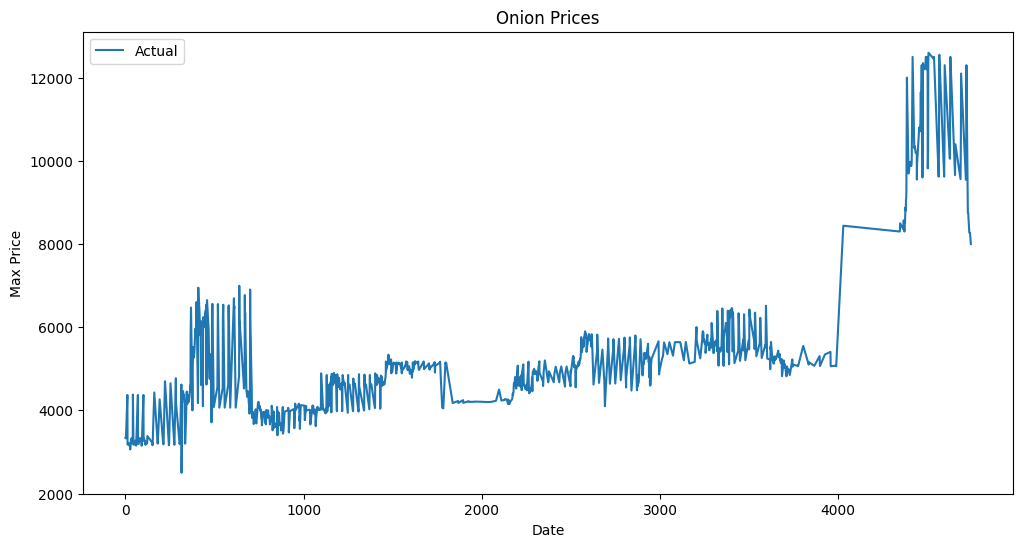

In [ ]:
# Visualize the data
plt.figure(figsize=(12, 6))
plt.plot(ts_data.index, ts_data['Max Price'], label='Actual')
plt.xlabel('Date')
plt.ylabel('Max Price')
plt.title('Onion Prices')
plt.legend()
plt.show()

In [ ]:
# Perform seasonal decomposition
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(ts_data['Max Price'], model='additive',period=365)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

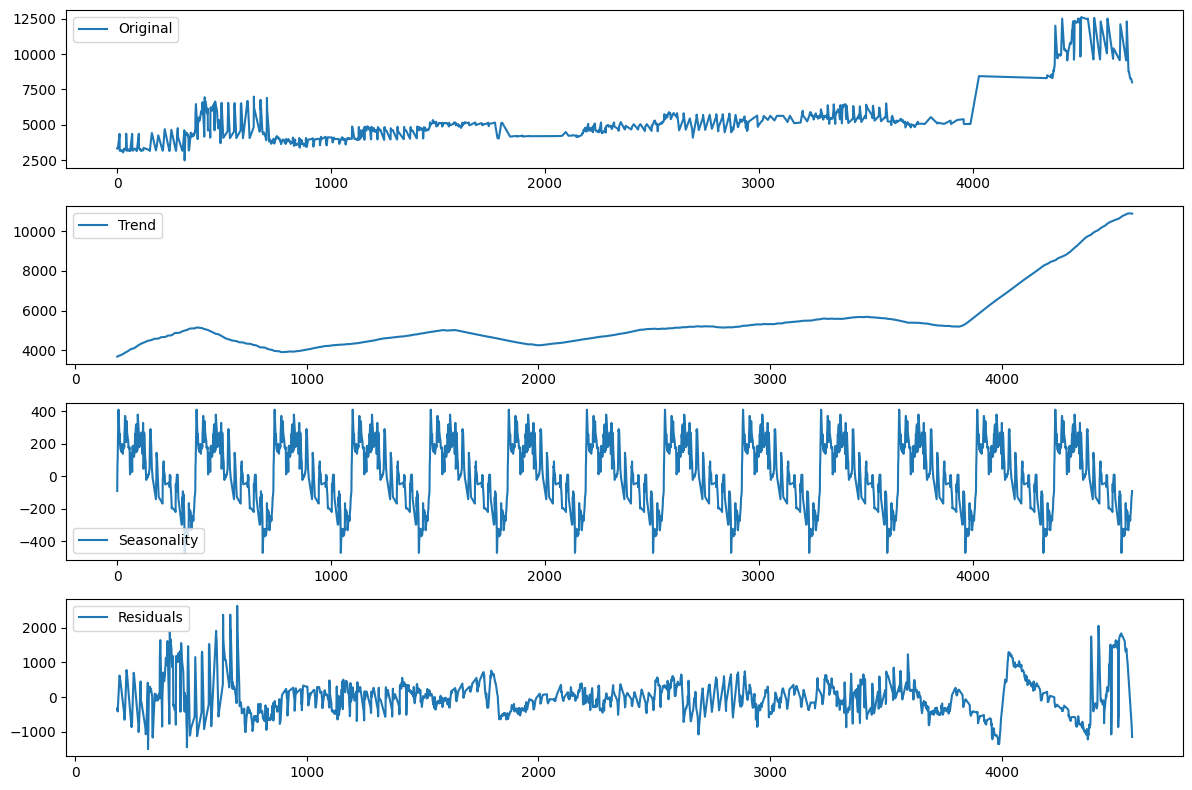

In [ ]:
# Plot the decomposition components
plt.figure(figsize=(12, 8))
plt.subplot(411)
plt.plot(ts_data.index, ts_data['Max Price'], label='Original')
plt.legend()
plt.subplot(412)
plt.plot(ts_data.index, trend, label='Trend')
plt.legend()
plt.subplot(413)
plt.plot(ts_data.index, seasonal, label='Seasonality')
plt.legend()
plt.subplot(414)
plt.plot(ts_data.index, residual, label='Residuals')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# Test for stationarity
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries):
    # Perform Dickey-Fuller test
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', 'Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput[f'Critical Value ({key})'] = value
    print(dfoutput)

In [ ]:
# Test stationarity of the original series
test_stationarity(ts_data['Max Price'])

Results of Dickey-Fuller Test:
Test Statistic                   -4.561370
p-value                           0.000152
Lags Used                        10.000000
Number of Observations Used    4736.000000
Critical Value (1%)              -3.431732
Critical Value (5%)              -2.862150
Critical Value (10%)             -2.567095
dtype: float64


In [ ]:
series1=ts_data['Max Price']

In [ ]:
# Create train and test sets
train_size = int(len(ts_data) * 0.9)
train_data = series1[:train_size]
test_data = series1[train_size:]

In [ ]:
len(train_data)

4272

In [ ]:
len(test_data)

475

In [ ]:
# Scale the data
scaler = MinMaxScaler()
scaled_train_data = scaler.fit_transform(train_data.values.reshape(-1, 1))

In [ ]:
# Define the number of time steps and create input sequences
n_steps = 30
X_train = []
y_train = []
for i in range(n_steps, len(scaled_train_data)):
    X_train.append(scaled_train_data[i - n_steps:i, 0])
    y_train.append(scaled_train_data[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

In [ ]:
# Reshape input sequences for LSTM [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [ ]:
# Build the BiLSTM model
model = Sequential()
model.add(Bidirectional(LSTM(50, return_sequences=True, input_shape=(n_steps, 1))))
model.add(Bidirectional(LSTM(50)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=50, batch_size=32)

Epoch 1/50
133/133 [==============================] - 12s 33ms/step - loss: 5.4058e-04
Epoch 2/50
133/133 [==============================] - 4s 33ms/step - loss: 3.9003e-04
Epoch 3/50
133/133 [==============================] - 6s 43ms/step - loss: 3.8153e-04
Epoch 4/50
133/133 [==============================] - 4s 33ms/step - loss: 3.7780e-04
Epoch 5/50
133/133 [==============================] - 5s 41ms/step - loss: 3.7184e-04
Epoch 6/50
133/133 [==============================] - 5s 38ms/step - loss: 3.5920e-04
Epoch 7/50
133/133 [==============================] - 4s 33ms/step - loss: 3.6861e-04
Epoch 8/50
133/133 [==============================] - 6s 42ms/step - loss: 3.6079e-04
Epoch 9/50
133/133 [==============================] - 4s 33ms/step - loss: 3.5571e-04
Epoch 10/50
133/133 [==============================] - 5s 35ms/step - loss: 3.4519e-04
Epoch 11/50
133/133 [==============================] - 5s 40ms/step - loss: 3.5732e-04
Epoch 12/50
133/133 [==============================

In [ ]:
# Prepare test data
scaled_test_data = scaler.transform(test_data.values.reshape(-1, 1))
X_test = []
y_test = []
for i in range(n_steps, len(scaled_test_data)):
    X_test.append(scaled_test_data[i - n_steps:i, 0])
    y_test.append(scaled_test_data[i, 0])
X_test, y_test = np.array(X_test), np.array(y_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [ ]:
# Generate predictions
predicted_prices = model.predict(X_test)
predicted_prices = scaler.inverse_transform(predicted_prices)

14/14 [==============================] - 3s 24ms/step


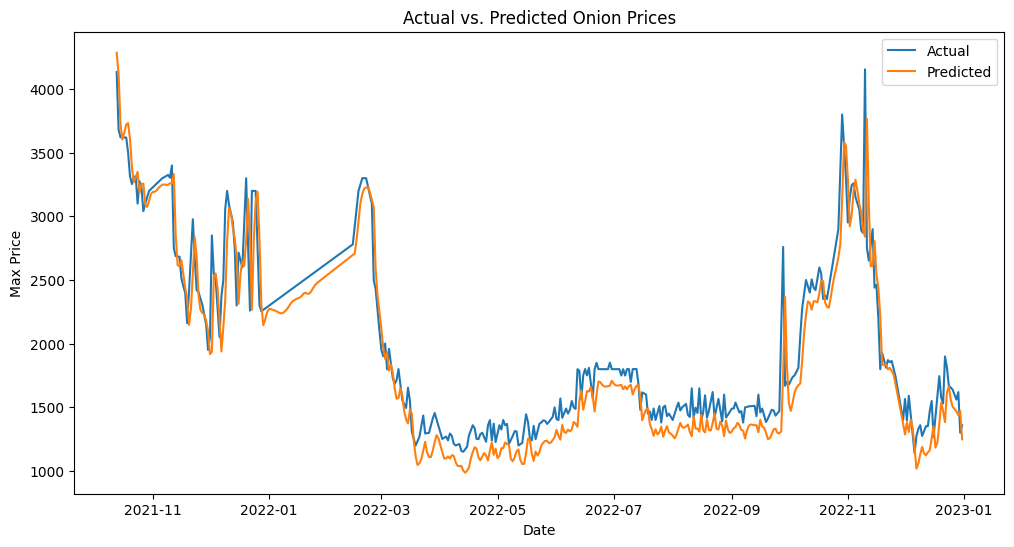

In [ ]:
# Plot test vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(ts_data.index[train_size + n_steps:train_size + n_steps + len(predicted_prices)], ts_data['Max Price'][train_size + n_steps:train_size + n_steps + len(predicted_prices)], label='Actual')
plt.plot(ts_data.index[train_size + n_steps:train_size + n_steps + len(predicted_prices)], predicted_prices[:, 0], label='Predicted')
plt.xlabel('Date')
plt.ylabel('Max Price')
plt.title('Actual vs. Predicted Onion Prices')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Calculate MAE
mae = mean_absolute_error(ts_data['Max Price'][train_size + n_steps:train_size + n_steps + len(predicted_prices)], predicted_prices[:, 0])
print(f"Mean Absolute Error (MAE): {mae}")

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(ts_data['Max Price'][train_size + n_steps:train_size + n_steps + len(predicted_prices)], predicted_prices[:, 0]))
print(f"Root Mean Squared Error (RMSE): {rmse}")

# Calculate MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape = mean_absolute_percentage_error(ts_data['Max Price'][train_size + n_steps:train_size + n_steps + len(predicted_prices)], predicted_prices[:, 0])
print(f"Mean Absolute Percentage Error (MAPE): {mape}%")

Mean Absolute Error (MAE): 166.43559579456345
Root Mean Squared Error (RMSE): 224.54306407565784
Mean Absolute Percentage Error (MAPE): 8.820944341632874%


In [ ]:
model.save('/content/drive/MyDrive/elai/onion_model')

148/148 [==============================] - 2s 10ms/step


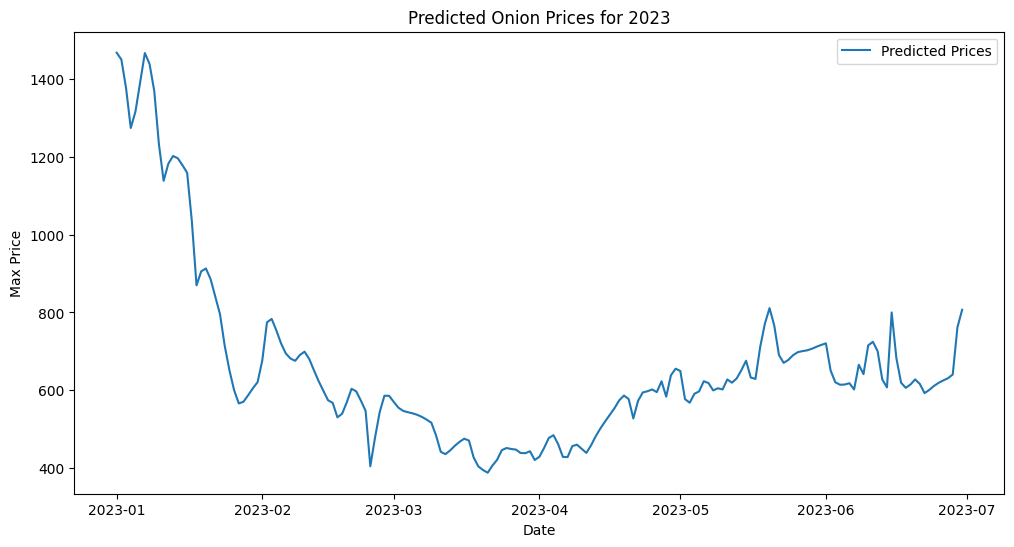

In [ ]:
# Prepare the input data for predicting 2023 prices
start_date_2023 = pd.to_datetime('2023-01-01')
end_date_2023 = pd.to_datetime('2023-06-30')
dates_2023 = pd.date_range(start=start_date_2023, end=end_date_2023, freq='D')

# Scale the input data
scaled_2023 = scaler.transform(ts_data['Max Price'].values.reshape(-1, 1))

# Reshape the input data to match the BiLSTM model's input shape
X_2023 = []
for i in range(n_steps, len(scaled_2023)):
    X_2023.append(scaled_2023[i - n_steps:i, 0])
X_2023 = np.array(X_2023)

# Predict the onion prices for 2023
predicted_prices = model.predict(X_2023.reshape(X_2023.shape[0], X_2023.shape[1], 1))

# Inverse scale the predicted prices
predicted_prices_2023 = scaler.inverse_transform(predicted_prices)

# Truncate the predicted prices array to match the length of dates_2023
predicted_prices_2023 = predicted_prices_2023[:len(dates_2023)]

# Create a DataFrame for the predicted prices
df_predicted_2023 = pd.DataFrame(data=predicted_prices_2023, index=dates_2023, columns=['Predicted Prices'])

# Plot the predicted prices for 2023
plt.figure(figsize=(12, 6))
plt.plot(df_predicted_2023.index, df_predicted_2023['Predicted Prices'], label='Predicted Prices')
plt.xlabel('Date')
plt.ylabel('Max Price')
plt.title('Predicted Onion Prices for 2023')
plt.legend()
plt.show()

In [ ]:
df_predicted_2023

Predicted Prices
2023-01-01       1467.897705
2023-01-02       1450.273682
2023-01-03       1376.659302
2023-01-04       1274.268555
2023-01-05       1316.692017
...                      ...
2023-06-26        625.101990
2023-06-27        630.764099
2023-06-28        640.275757
2023-06-29        761.523438
2023-06-30        806.789917

[181 rows x 1 columns]